In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [49]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')

In [50]:
df.head()

,Ano,Lula_art,Lula_ind,Lula_art_ind,Lula_oceanica_art,Calamar_ind,Polvo_art,Polvo_ind,Polvo_art_ind,Polvo_cabecinha_art,...,Mexilhao_art,Mexilhao_ind,Mexilhao_mangue_art,Caramujo_art,Caramujo_ind,Vieira_ind,Berbigao_art,Vongole_art,TOTAL_MOLLUSCS,TOTAL_GROUPS_F&M
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28137.0
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27432.0
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26648.0
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24552.0
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22755.0


In [51]:
df[['Lula_art', 'Lula_ind']] = df[['Lula_art', 'Lula_ind']].fillna(0)
df['Lula_art_ind'] = df['Lula_art_ind'].fillna(0)
df['Lula_sum'] = df['Lula_art'] + df['Lula_ind'] + df['Lula_art_ind']
lula_total = pd.DataFrame(df[['Ano', 'Lula_sum']].values, columns=['Ano', 'Lula_total'])
df = lula_total.replace(0, np.nan)

print(df)

       Ano  Lula_total
0   1950.0         NaN
1   1951.0         NaN
2   1952.0         NaN
3   1953.0         NaN
4   1954.0         NaN
..     ...         ...
68  2018.0     78.4235
69  2019.0     80.8258
70  2020.0     43.4189
71  2021.0     82.2118
72  2022.0     76.8663

[73 rows x 2 columns]


In [59]:
x0 = df[['Ano', 'Lula_total']].dropna().values
df_x0 = pd.DataFrame(x0, columns=['Ano', 'Lula_total'])


Epoch 1/1000


C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 194us/step - accuracy: 0.0000e+00 - loss: 0.7941
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.6983
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - loss: 0.6155
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - loss: 0.4968
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step - accuracy: 0.0000e+00 - loss: 0.5182
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.4355
Epoch 7/1000
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.3407

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.0000e+00 - loss: 0.3740
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.0000e+00 - loss: 0.4887
Epoch 9/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.4514
Epoch 10/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.0000e+00 - loss: 0.4185
Epoch 11/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.4279
Epoch 12/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136us/step - accuracy: 0.0000e+00 - loss: 0.3694
Epoch 13/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - loss: 0.3628
Epoch 14/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - loss: 0.3972
Epoch 15/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.0000e+00 - loss: 0.3521
Epoch 16/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.0000e+00 - loss: 0.3852
Epoch 17/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step - accuracy: 0.0000e+00 - loss: 

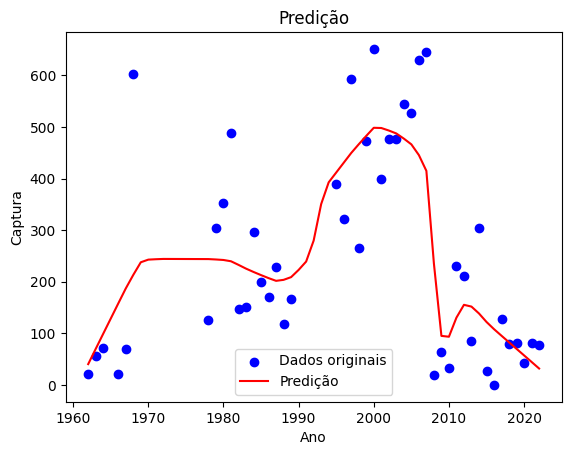

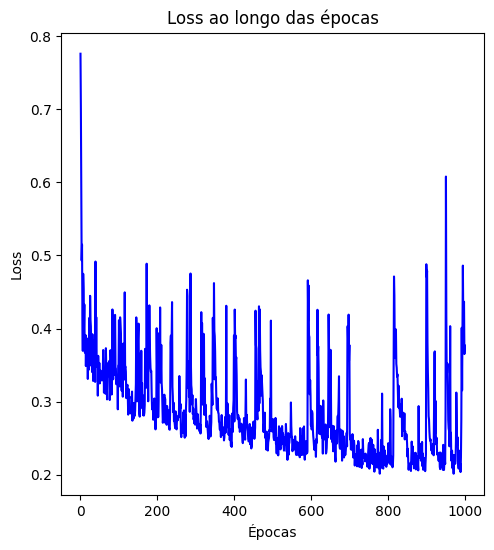

In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Supondo que o DataFrame 'df_x0' já esteja definido
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Lula_total'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

# Treinando o modelo com batch size de 32 e 50 iterações por época
history = model.fit(x_normalized, y_normalized, epochs=1000, batch_size=12, steps_per_epoch=50, verbose=True)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()
